In [39]:
from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
pd.options.display.expand_frame_repr = False

In [40]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [41]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
def norm_data(df, pass_columns=None):
    """ Нормализуем данные """
    if pass_columns is None:
        pass_columns = []
    for col in df.columns:
        label_encoder = LabelEncoder()
        scaler = StandardScaler()
        if df[col].dtype.kind in 'O':
            df[col] = label_encoder.fit_transform(df[col])
        elif df[col].dtype.kind in 'iufc':
            if (df[col].min() != 0 and df[col].max() != 1) and col not in pass_columns:
                df[col] = scaler.fit_transform(df[[col]])
            else:
                pass
    return df

,X1,X2,X3
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196
5,168,74,220
6,137,54,188
7,149,61,188
8,159,65,207
9,128,46,167


,X1,X2,X3
0,-1.392392,-1.203018,-1.332610
1,-0.545762,-0.397519,-0.666305
2,0.223902,0.523051,-0.060573
3,0.916600,1.213479,0.969171
4,0.300869,0.177837,0.060573
5,1.378398,1.328551,1.514330
6,-1.007560,-0.972876,-0.424012
7,-0.083963,-0.167376,-0.424012
8,0.685700,0.292909,0.726878
9,-1.700257,-1.893446,-1.696050


<Axes: >

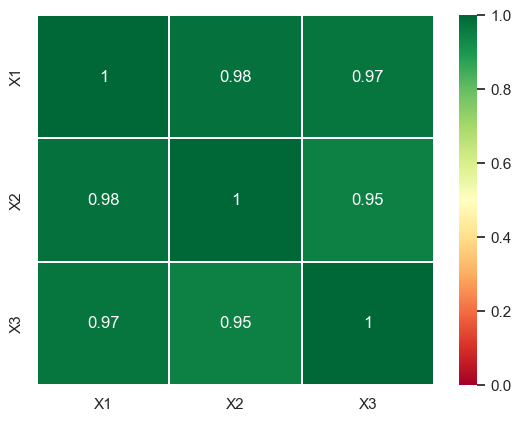

In [43]:
# Read dataframe
data = pd.read_excel('blood.xlsx')
data.dropna(inplace=True)
display(data)

# Dependent variable
explore_column = 'X1' 
 
# Normalization
data = norm_data(data)
display(data)

# Correlation
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

### Биномиальная регрессия

In [44]:
class RidgeRegressionResearch:
    def __init__(self, df, column, influence_measures_filename=None):
        self.filename = influence_measures_filename
            
        self.column = column
        self.x = df.drop(columns=column)
        self.y = df[column]
        
        self.alphas = np.logspace(-6, 6, 13)
        self.model = RidgeCV(alphas=self.alphas, store_cv_values=True)
        self.results = self.model.fit(self.x, self.y) 
        
        X = sm.add_constant(self.x)
        alpha = 1.0  # Параметр регуляризации
        model = sm.OLS(self.y, X)
        results = model.fit_regularized(alpha=alpha, L1_wt=0.01, refit=True)
        
        # Выведите результаты
        print(results.summary())
    
    def info(self):    
        # Получение мер влиятельности для каждого наблюдения
        print('==============================================================================')
        
    def draw_plots(self):
        # Построим график важности признаков
        plt.figure(figsize=(6, 6))
        plt.bar(range(self.x.shape[1]), self.model.coef_, tick_label=self.x.columns)
        plt.title('Feature Importance in Ridge Regression')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.show()
        
        # Построим график кросс-валидации
        cv_mean = np.mean(self.model.cv_values_, axis=0)
        cv_std = np.std(self.model.cv_values_, axis=0)
        
        plt.figure(figsize=(10, 6))
        plt.semilogx(self.model.alphas, cv_mean, marker='o', label=f'Min MSE: {np.min(cv_mean):.4f}\nBest alpha: {self.model.alpha_} ')
        plt.fill_between(self.model.alphas, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2)
        
        plt.xlabel('log(alpha)')
        plt.ylabel('Mean Squared Error')
        plt.title('Cross-Validation Plot for Ridge Regression')
        plt.legend(loc='lower right', frameon=True)
        plt.show()
    
    def run_tests(self):
        # Проведём тесты на значимость построенного уравнения регрессии
        
        # Проверяем модель на мультиколлинеарность данных.
        print('==============================================================================')
        vif_tol_data = pd.DataFrame()
        vif_tol_data["Variable"] = self.x.columns
        vif_tol_data["VIF"] = [variance_inflation_factor(self.x.values, i) for i in range(self.x.shape[1])]
        vif_tol_data["Tolerance"] = 1 / vif_tol_data["VIF"]
        display(vif_tol_data)

### Строим базовую _logit_ модель

                            OLS Regression Results                            
Dep. Variable:                     X1   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     189.9
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           4.37e-08
Time:                        01:17:42   Log-Likelihood:                 5.1027
No. Observations:                  11   AIC:                            -4.205
Df Residuals:                       9   BIC:                            -3.012
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

D:\PythonEnv\Matt\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


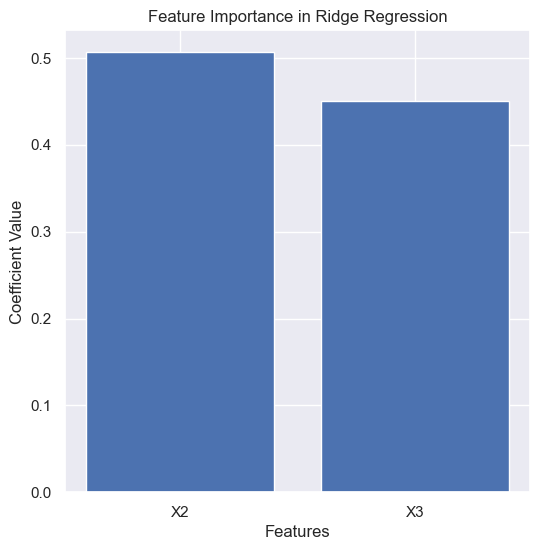

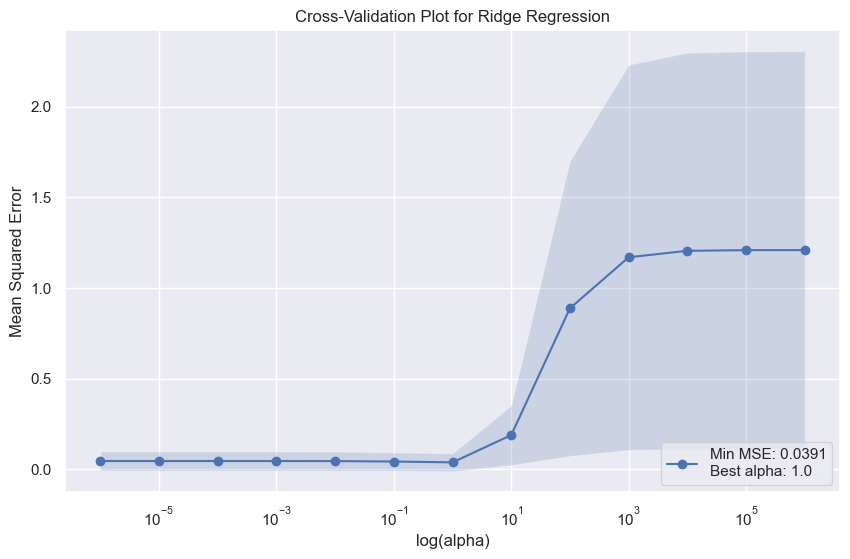

,Variable,VIF,Tolerance
0,X2,9.525022,0.104987
1,X3,9.525022,0.104987


In [45]:
ridge_research = RidgeRegressionResearch(data, column=explore_column)
ridge_research.info()
ridge_research.draw_plots()
ridge_research.run_tests()

### Строим базовую _probit_ модель

In [46]:
probit_research = RidgeRegressionResearch(data, column=explore_column, family='probit')
probit_research.info()
probit_research.draw_plots()

TypeError: RidgeRegressionResearch.__init__() got an unexpected keyword argument 'family'

### Попытаемся улучшить базовую модель при помощи (AIC/BIC) 

In [ ]:
def stepwise_selection(df, column, criteria: str = 'AIC'):
    """ 
        Улучшаем модель при помощи:
            ::AIC (Akaike Information Criterion) 
                            или
            ::BIC (Bayesian Information Criterion) 
    """
    
    # Проверка, что criteria является строкой и принимает только 'AIC' или 'BIC'
    if not isinstance(criteria, str) or criteria not in ['AIC', 'BIC']:
        raise ValueError("Параметр 'criteria' должен быть строкой ('AIC' или 'BIC').")
    else:
        criteria = criteria.upper()
    
    
    drop_index = None
    output = ('                                    STEPS                                     \n'
              '==============================================================================\n')
    
    x = df.drop(columns=column)
    y = df[column]
    remaining_features = list(x.columns)
    best_model = sm.OLS(y, sm.add_constant(x[remaining_features])).fit()
    best_criterion = best_model.aic if criteria == 'AIC' else best_model.bic
    
    k = True
    while k:
        k = False
        output += (f'Selected Features: {remaining_features} \n'
                   f'{criteria}: {best_criterion} \n')
        
        for index in range(len(remaining_features)):
            features = remaining_features[:index] + remaining_features[(index+1):]
            model = sm.OLS(y, sm.add_constant(x[features])).fit()
            criterion = model.aic if criteria == 'AIC' else model.bic
    
            if criterion < best_criterion:
                k = True
                best_criterion = criterion
                best_model = model
                drop_index = index

        if k:
            remaining_features.pop(drop_index)
    
    print(output)
    return best_model, remaining_features

In [ ]:
# Пошаговый отбор признаков с использованием AIC
new_model, selected_features = stepwise_selection(data, column=explore_column, criteria='AIC')

### Проведём исследование улучшенной модели

In [ ]:
enhanced_research = RidgeRegressionResearch(data[selected_features + [explore_column]], column=explore_column, family='logit')
enhanced_research.info()
enhanced_research.run_tests()
enhanced_research.draw_plots()

In [ ]:
enhanced_research = RidgeRegressionResearch(data[selected_features + [explore_column]], column=explore_column, family='probit')
enhanced_research.info()
enhanced_research.run_tests()
enhanced_research.draw_plots()